In [1]:
#Importing packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from skimage import exposure

In [2]:
#Loading the pickle file containing a dictionary with 
#patient ID and image ID for keys and the cleaned images for values 
#(from the Data Wrangling notebook).
folder_path = '/kaggle/input/rsna-breast-cancer-detection-data-wrangling/'

with open(folder_path + 'cleaned_images.pickle', 'rb') as file:
    img_dict = pickle.load(file)
    
#Loading the cleaned csv file (also from the Data Wrangling notebook).
df = pd.read_csv(folder_path + 'cleaned_data.csv')

In [3]:
#Creating two new dataframes, by filtering df according to whether the patient has cancer or not.
df_cancer = df[df['cancer_1']==1].reset_index()
df_no_cancer = df[df['cancer_1']==0].reset_index()
print(df_cancer.shape)
print(df_no_cancer.shape)

(662, 28)
(22972, 28)


Next, we create the matrix X of features. Each feature is a numpy array consisting of the values of all the pixels in the image, concatenated to the values of the columns of df_cancer and df_no_cancer.

We have a very imbalanced dataset, with many more images without cancer than with cancer. For now we will use all the images with cancer, and twice as many images without cancer. Later on (after the train split test) we will oversample the images with cancer to obtain a more balanced dataset.

In [4]:
X = []

for i in range(len(df_cancer)):
    key = str(df_cancer['patient_id'][i]) + '/' + str(df_cancer['image_id'][i])
    
    arr = np.array(img_dict[key]).ravel()
    
    arr = np.append(arr, df_cancer['age'][i])
    arr = np.append(arr, df_cancer['laterality_L'][i])
    arr = np.append(arr, df_cancer['view_CC'][i])
    arr = np.append(arr, df_cancer['biopsy_0'][i])
    arr = np.append(arr, df_cancer['implant_0'][i])
    arr = np.append(arr, df_cancer['invasive_0'][i])
    arr = np.append(arr, df_cancer['BIRADS_0.0'][i])
    arr = np.append(arr, df_cancer['BIRADS_1.0'][i])
    arr = np.append(arr, df_cancer['BIRADS_2.0'][i])
    arr = np.append(arr, df_cancer['density_A'][i])
    arr = np.append(arr, df_cancer['density_B'][i])
    arr = np.append(arr, df_cancer['density_C'][i])
    arr = np.append(arr, df_cancer['difficult_negative_case_False'][i])
    
    X.append(arr)
    
for i in range(2*len(df_cancer)):
    key = str(df_no_cancer['patient_id'][i]) + '/' + str(df_no_cancer['image_id'][i])
    
    arr = np.array(img_dict[key]).ravel()
    
    arr = np.append(arr, df_no_cancer['age'][i])
    arr = np.append(arr, df_no_cancer['laterality_L'][i])
    arr = np.append(arr, df_no_cancer['view_CC'][i])
    arr = np.append(arr, df_no_cancer['biopsy_0'][i])
    arr = np.append(arr, df_no_cancer['implant_0'][i])
    arr = np.append(arr, df_no_cancer['invasive_0'][i])
    arr = np.append(arr, df_no_cancer['BIRADS_0.0'][i])
    arr = np.append(arr, df_no_cancer['BIRADS_1.0'][i])
    arr = np.append(arr, df_no_cancer['BIRADS_2.0'][i])
    arr = np.append(arr, df_no_cancer['density_A'][i])
    arr = np.append(arr, df_no_cancer['density_B'][i])
    arr = np.append(arr, df_no_cancer['density_C'][i])
    arr = np.append(arr, df_no_cancer['difficult_negative_case_False'][i])
    
    X.append(arr)

We create the corresponding array Y of labels.

In [5]:
Y = []

for i in range(len(df_cancer)):
    Y.append(df_cancer['cancer_1'][i])
    
for i in range(2*len(df_cancer)):
    Y.append(df_no_cancer['cancer_1'][i])

# Baseline models

After the data augmentation step below, the train data will be evenly split between cancerous images and non-cancerous images. Based on that information, we can estimate baseline values for the accuracy of the training set, as follows:

If for example we randomly classify each mammogram as cancerous or non-cancerous, then the probability that we classify the images correctly will be: (0.5) * (0.5) + (0.5) * (0.5) = 0.5. To see this, we note that the first term (0.5) * (0.5) is the probability that we classify correctly as cancerous (because there is a 0.5 chance that the image is classified as cancerous, and also a 0.5 chance that the image is actually cancerous). Similarly, the second term (0.5) * (0.5) is the probability that we classify correctly as non-cancerous.

Another simple baseline model is to simply classify all the images as cancerous, or classify all of them as non-cancerous. Such a baseline model is also correct half of the times, so its accuracy is 50 percent.

Therefore, if our models below have an accuracy better than 50 percent (on the training set), then the models are better than the two baseline models described above.

# Logistic Regression

In [6]:
#Creating a pipeline to scale the data, use 120 principal 
#components, and do 3-fold cross-validation.

steps = [("scaler", StandardScaler()),
         ("pca", PCA(n_components=100)),
         ("logreg", LogisticRegression(solver='liblinear', max_iter = 500))]
pipeline = Pipeline(steps)
parameters = {"logreg__C": [10, 100]}
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.75, random_state = 13)
cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=3)

Now we augment the number of images with cancer by a factor of 2 by oversampling (with flipped images).

In [7]:
Xtrain_augmentation = []
Ytrain_augmentation = []

for i in range(len(Xtrain)):
    if Ytrain[i] == 1:
        img_part = Xtrain[i][:(512**2)]
        non_img_part = Xtrain[i][(512**2):]
        flipped_img_part = np.flipud(img_part.reshape(512,512)).ravel()
        new_arr = np.concatenate((flipped_img_part, non_img_part))
        Xtrain_augmentation.append(new_arr)
        
        #Xtrain_augmentation.append(Xtrain[i])
        Ytrain_augmentation.append(Ytrain[i])
        
Xtrain = Xtrain + Xtrain_augmentation
Ytrain = Ytrain + Ytrain_augmentation

In [8]:
#Checking that the train dataset is now balanced.
print(len(Xtrain), len(Ytrain))
print(len(Xtrain_augmentation), len(Ytrain_augmentation))
print(Ytrain.count(0))
print(Ytrain.count(1))

1989 1989
500 500
989
1000


In [9]:
cv.fit(Xtrain, Ytrain)
print(cv.best_score_)
print(cv.best_params_)

0.6169418990052646
{'logreg__C': 10}


accuracy score: 0.607645875251509
f1 score 0.4247787610619469


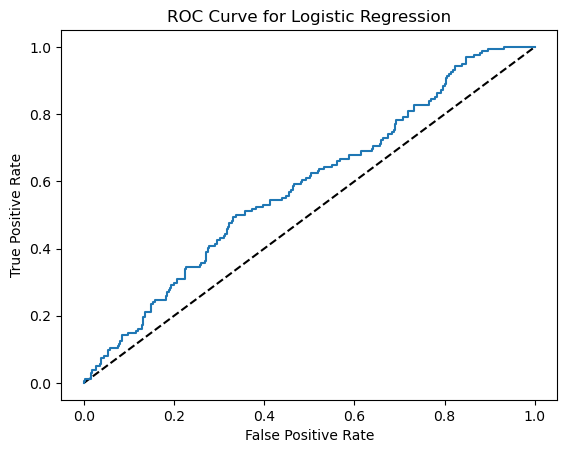

In [10]:
Ypred = cv.predict(Xtest)
Ypred_probs = cv.predict_proba(Xtest)[:,1]
print("accuracy score:", accuracy_score(Ytest, Ypred))
print("f1 score", f1_score(Ytest, Ypred))
fpr, tpr, thresholds = roc_curve(Ytest, Ypred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

We see that the accuracy score on the train set is higher than the accuracy of the baseline models !

In [11]:
print(auc(fpr, tpr))

0.5855352865303114


# Random Forest

In [12]:
#Creating a pipeline to scale the data and do 3-fold cross-validation.

steps = [("scaler", StandardScaler()),
         ("pca", PCA(n_components=100)),
         ("randomforest", RandomForestClassifier(random_state=47))]
pipeline = Pipeline(steps)
parameters = {"randomforest__n_estimators": [1000,1500]}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=3)

In [13]:
cv.fit(Xtrain, Ytrain)
print(cv.best_score_)
print(cv.best_params_)

0.6107249864846107
{'randomforest__n_estimators': 1500}


accuracy score: 0.6458752515090543
f1 score 0.4133333333333334


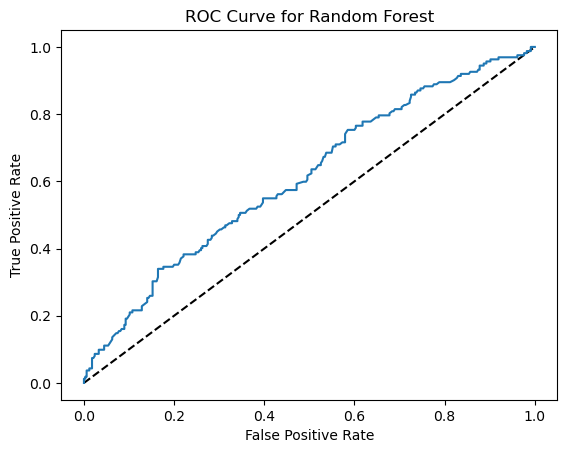

In [14]:
Ypred = cv.predict(Xtest)
Ypred_probs = cv.predict_proba(Xtest)[:,1]
print("accuracy score:", accuracy_score(Ytest, Ypred))
print("f1 score", f1_score(Ytest, Ypred))
fpr, tpr, thresholds = roc_curve(Ytest, Ypred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

In [15]:
print(auc(fpr, tpr))

0.6100608070757324


# Gradient boosting

In [16]:
#Creating a pipeline to scale the data and do 3-fold cross-validation.

steps = [("scaler", StandardScaler()),
         ("pca", PCA(n_components=100)),
         ("gradientboosting", GradientBoostingClassifier(random_state=47))]
pipeline = Pipeline(steps)
parameters = {"gradientboosting__max_depth": [2,4], 
              "gradientboosting__n_estimators": [1000,1500]}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1',cv=3)

In [17]:
cv.fit(Xtrain, Ytrain)
print(cv.best_score_)
print(cv.best_params_)

0.6307619077085446
{'gradientboosting__max_depth': 2, 'gradientboosting__n_estimators': 1500}


accuracy score: 0.6056338028169014
f1 score 0.42011834319526625


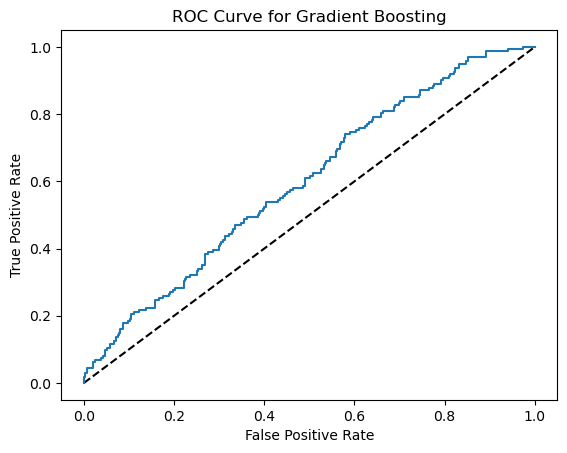

In [18]:
Ypred = cv.predict(Xtest)
Ypred_probs = cv.predict_proba(Xtest)[:,1]
print("accuracy score:", accuracy_score(Ytest, Ypred))
print("f1 score", f1_score(Ytest, Ypred))
fpr, tpr, thresholds = roc_curve(Ytest, Ypred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.show()

In [19]:
print(auc(fpr, tpr))

0.5982679196609545
